In [1]:
import sys
sys.path.append("../") # go to parent dir
sys.path.append("../extract_centerline/")
sys.path.append("../extract_centerline/bin/")
sys.path.append("util/")

In [2]:
# Import libraries 
import time
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import subprocess 
import collections
import itertools

# Import self-made code
import wireskeletonise 
from centerline_extraction import * 
from get_biggest_spline import * 
from util import *

# Use full browser width
from IPython.core.display import display, HTML
display(HTML(""))

# Start matlab engine 


In [3]:
# python -m ipykernel install --user --name=my-virtualenv-name
import matlab.engine
import pathlib
import os

# Show data
eng_start = time.time()
eng = matlab.engine.start_matlab()
print('Engine start took', time.time() - eng_start, 'seconds')

_ = eng.addpath(os.path.join(str(pathlib.Path().absolute().parents[0]), 'simulation'))
_ = eng.addpath(os.path.join(str(pathlib.Path().absolute().parents[0]), 'simulation/util'))

Engine start took 5.504873037338257 seconds


# Import segmentation methods


In [4]:
# Import models 
from Classical_methods import laplace_segmentation
import Unet_pytorch
import Segnet_pytorch

# Load UNet & SegNet
save_path = 'saved_models/'
num_class = 1
Unet_model = Unet_pytorch.UNet(num_class)
Segnet_model = Segnet_pytorch.SegNet(num_class)
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
Unet_model.load_state_dict(torch.load(save_path+'unet_all_1', map_location=device))
Segnet_model.load_state_dict(torch.load(save_path+'segnet_all_1.pth', map_location=device))
print("Using", device)
Unet_model = Unet_model.to(device)
Segnet_model = Segnet_model.to(device)

Using cuda:0


# Import metrics


In [5]:
import metrics
HAUS_D = metrics.hausdorff_distance
MSE = metrics.MSE 
TIP_D = metrics.tip_distance  

# Evaluation 0 :
## Use validation dataset for testing 


In [6]:
from load_data import *
import dataset
from sklearn.model_selection import train_test_split

X, y, pts = load_data('.', '../data/dataset_all_1', v73 = True)
batch_size = 5
test_length = round(y.shape[0] * 0.2)
pts = pts[:, :, ::-1]
X_train, y_train, X_test, y_test = X[:-test_length], y[:-test_length], X[-test_length:], y[-test_length:]
pts_train, pts_test = pts[:-test_length], pts[-test_length:]
dataloaders = dataset.gen_dataloaders(X_train, X_test, y_train, y_test, batch_size)

{'train': 5600, 'val': 1400}


In [7]:
def evaluate_method(method, metric, n = None):
    metrics = []
    for i, (simulated, ground_truth) in tqdm(enumerate(dataloaders['val'])):
        if n is not None and i >= n:
            break
        segmented = method(simulated.float().squeeze(1).detach().numpy())
        metrics.append(metric(segmented, ground_truth.numpy()))
    return np.array(metrics).mean()

In [8]:
methods = {'Laplace filter': lambda x: np.array([laplace_segmentation(x_i) for x_i in x]),
           #'Random forest': lambda x: np.array([rf_segmentation(x_i) for x_i in x]),
           'UNet': lambda x: Unet_model((torch.Tensor(x).unsqueeze(1).to(device))).detach().cpu().numpy(),
           'SegNet': lambda x: Segnet_model((torch.Tensor(x).unsqueeze(1).to(device))).detach().cpu().numpy()}

for name, method in methods.items():
    score = evaluate_method(method, MSE, n =20).mean()
    print(f'{name} had MSE of {score}')


Laplace filter had MSE of 0.3510791015625



UNet had MSE of 0.01003009219146912



SegNet had MSE of 0.010241122536515783


# Evaluation 1 :

## Use real-time simulated images from matlab engine

In [42]:
im_size = eng.cell2mat([256.0, 192.0])
eng.addpath('util/')

def evaluate_ablation(methods, metric, spline_metric, parameters, loop_prob = 0.7, verbose=0, n_samples=1, experiment='test'):

    # Create results directory
    results_dir = 'results/'+experiment+'/'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
        
    # Define varying parameter 
    variants = [v for v in parameters.keys() if len(np.unique(parameters[v])) > 1]
        
    if len(variants) == 0: 
        print(f'Warning, varying {len(variants)} parameter(s)')
        variant = 'Spline'
        variant_pars = [0]
        n_values = 1
        for key, value in parameters.items():
            parameters[key] = [value[0]]
    else: 
        variant = variants[0]
        print(f'Varying {variant}...')
        variant_pars = parameters[variants[0]]
        n_values = len(variant_pars)
    
    # Simulate the images for varying parameter
    sim_start = time.time()
    blur_filter = eng.gen_blur_filter(float(250), float(1.3));
    simulated_images = [[0 for x in range(n_values)] for y in range(n_samples)]
    ground_truths = [[0 for x in range(n_values)] for y in range(n_samples)]
    ground_truth_pts = [[0 for x in range(n_values)] for y in range(n_samples)]
    
    for n in range(n_samples):
        seed = eng.rng('shuffle') 
        pts, _ = eng.gen_spline_realistic(im_size, 100.0, loop_prob, nargout = 2)
        gt_pts = np.array(pts._data).reshape(pts.size, order='F').T 
        gt_pts = gt_pts[:,1:]
        gt_pts[:,[0, 1]] = gt_pts[:,[1, 0]]   
        
        for i, (s, u, us, tc, sa, ra) in enumerate((np.array(list(parameters.values())).T.tolist())):
            eng.rng(seed)
            #eng.rng(1234)
            ground_truth, simulated = np.array(eng.simulate(pts,im_size,blur_filter,1,0,0, 
                                                            eng.cell2mat([s, s]), 
                                                            eng.cell2mat([tc,tc]),
                                                            eng.cell2mat([u, u]),
                                                            eng.cell2mat([us,us]),
                                                            eng.cell2mat([sa,sa]),
                                                            eng.cell2mat([ra,ra]),nargout=2))
            simulated_images[n][i] = simulated
            ground_truths[n][i] = ground_truth
            ground_truth_pts[n][i] = gt_pts

    # Segment using every method
    simulated_images, ground_truths = np.array(simulated_images), np.array(ground_truths)
    segmented, scores_spline, _centerlines, _splines = {}, {}, {}, {}
    segmented = collections.defaultdict(list)
    metric_dic = collections.defaultdict(dict)

    for name, method in methods.items():
        for image in simulated_images:
            segmented[name].append(method(image)) 

        for m in metric: 
            metric_value = [[0 for x in range(n_values)] for y in range(n_samples)]
            for i,(seg, gt) in enumerate(zip(segmented[name],ground_truths)):
                metric_value[i] = m(seg,gt)
            metric_dic[m.__name__][name] = metric_value
        
        for s in spline_metric: 
            centerlines = [[0 for x in range(n_values)] for y in range(n_samples)]
            cl_pts = [[0 for x in range(n_values)] for y in range(n_samples)]
            
            if s.__name__ == 'hausdorff_distance':
                metric_dic['average_hausdorff'].setdefault(name,[[] for x in range(n_samples)])
                metric_dic['maximum_hausdorff'].setdefault(name,[[] for x in range(n_samples)])
            else: 
                metric_dic[s.__name__].setdefault(name,[[] for x in range(n_samples)])
            
            for nn, (seg, gt_pts) in enumerate(zip(segmented[name], ground_truth_pts)):
                for ii,(v, v_pt) in enumerate(zip(seg,gt_pts)): 
                    v = np.squeeze(v)
                    if not isinstance(v,bool):
                        v = v>0.2
                    centerline, cl_pt = get_centerline(v,original_dir,'binary') 
                    #cl_pt = get_biggest_spline(cl_pt)
                    cl_pt = np.flip(cl_pt,axis=0)
                    centerlines[nn][ii] = centerline
                    cl_pts[nn][ii] = cl_pt[-1]                     
                    
                    if s.__name__ == 'hausdorff_distance':
                        average, maximum = s(v_pt,cl_pt)
                        metric_dic['average_hausdorff'][name][nn].append(average)
                        metric_dic['maximum_hausdorff'][name][nn].append(maximum)
                    else: 
                        metric_dic[s.__name__][name][nn].append(s(v_pt,cl_pt))
                    
        _centerlines[name] = np.array(centerlines)
        _splines[name] = np.array(cl_pts)
            
    ## START DISPLAY ## 
    visualisation_simulated = simulated_images[0,:,:,:]
    visualisation_ground_truths = ground_truths[0,:,:,:]
    visualisation_ground_truth_pts = np.array(ground_truth_pts)[0,:,:,:]

    # Plot qualitative results (input and outpus of each method) 
    for i, method in enumerate(methods.keys()):
        
        visualisation_segmented = np.array(segmented[method])[0,:,:,:]
        visualisation_centerlines = np.array(_centerlines[method])[0,:,:,:]
        visualisation_splines = np.array(_splines[method])[0,:,:]
        
        fig = plt.figure(figsize=[25, 8])
        fig.suptitle(f'Segmentation output ({method}) for varying {variant}\n', fontsize=15)    
        ax = [plt.subplot(4,n_values,i+1) for i in range(4 * n_values)]
        for i, (v, sim, gt, out, lin, pts, gt_pts) in enumerate(zip(variant_pars,visualisation_simulated,visualisation_ground_truths,visualisation_segmented,visualisation_centerlines,visualisation_splines,visualisation_ground_truth_pts)):
            ax[i].imshow(sim, cmap='gray')
            ax[i].axis('off')
            if len(variants) == 1:
                ax[i].set_title(round(v, 2))
            ax[i+ n_values].axis('off')
            ax[i+ n_values].imshow(gt, cmap='gray')
            ax[i+ n_values].scatter(gt_pts[len(gt_pts)-1,0],gt_pts[len(gt_pts)-1,1], color='b')
            ax[i + n_values*2].axis('off')
            try:
                ax[i + n_values*2].imshow(out.squeeze(0), cmap='gray')
            except:
                ax[i + n_values*2].imshow(out,cmap='gray')
            ax[i + n_values*3].axis('off')
            ax[i + n_values*3].imshow(lin, cmap='gray')
            ax[i + n_values*3].scatter(pts[0],pts[1],color='r')
            ax[i + n_values*3].scatter(gt_pts[len(gt_pts)-1,0],gt_pts[len(gt_pts)-1,1], color='b')
        ax[0].axis('on')
        ax[0].set_yticklabels([])
        ax[0].set_xticklabels([])
        ax[0].set_ylabel('Input')
        ax[n_values].axis('on')
        ax[n_values].set_yticklabels([])
        ax[n_values].set_xticklabels([])
        ax[n_values].set_ylabel('Ground Truth')
        ax[n_values*2].axis('on')
        ax[n_values*2].set_yticklabels([])
        ax[n_values*2].set_xticklabels([])
        ax[n_values*2].set_ylabel('Segmentation')
        ax[n_values*3].axis('on')
        ax[n_values*3].set_yticklabels([])
        ax[n_values*3].set_xticklabels([])
        ax[n_values*3].set_ylabel('Spline')
        plt.subplots_adjust(wspace=-0.85, hspace=-0)
        if verbose: 
            plt.savefig(results_dir+fig._suptitle.get_text())
        plt.show()

    print('Evaluation took', time.time() - sim_start, 'seconds')
    
    return metric_dic, variant, variant_pars
    

In [74]:
def plot_metric(metric_dic, variant, pars, verbose = 0, directory = None): 

    # Plot performance of metrics against the changing parameter
    for k,v in metric_dic.items():
        fig,ax1 = plt.subplots(figsize=(15,8))
        colors = itertools.cycle(["r", "b", "g"])

        for kk,vv in v.items():
            c = next(colors)
            ax = ax1

            if kk == 'Laplace filter':
                ax2=ax.twinx()
                ax = ax2
                ax.set_ylabel('Laplace filter axis')
            mean_metric = np.quantile(vv, 0.5, axis=0)
            lower_quantile = np.quantile(vv, 0.25, axis=0)
            upper_quantile = np.quantile(vv, 0.75, axis=0)
            ax.plot(pars, mean_metric, lw=2, label=kk, color=c)
            ax.fill_between(pars, lower_quantile, upper_quantile, facecolor=c, alpha=0.2)
        
        ax.set_xlabel(variant)
        ax.set_ylabel(k)   
        ax.legend()
        ax.set_title(f'{k} against\n varying {variant}\n', fontsize=15)
        fig.tight_layout()
        
        if verbose:
            plt.savefig(directory + f'{k} against\n varying {variant}\n')
        plt.show()

/home/mmu18/Desktop/Projects/AIWire/segmentation
/home/mmu18/Desktop/Projects/AIWire/segmentation
Varying Sigma...


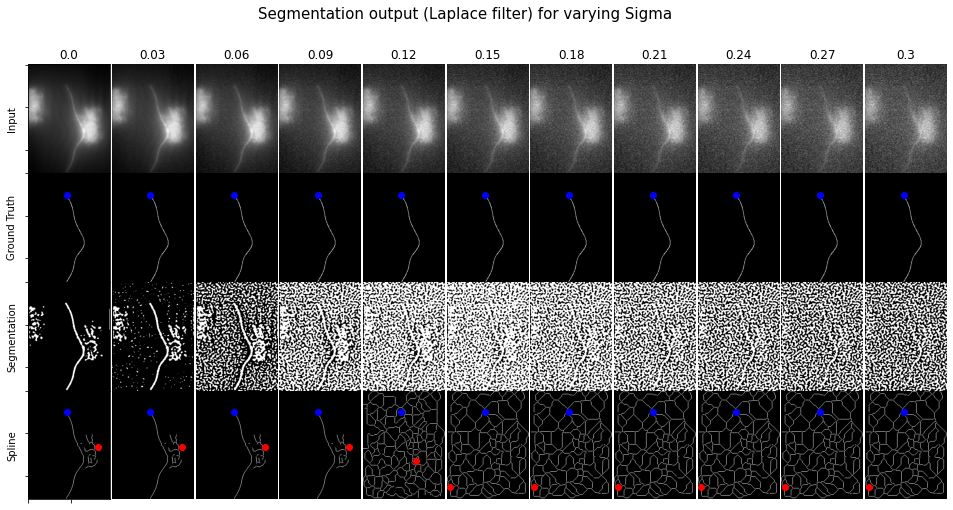

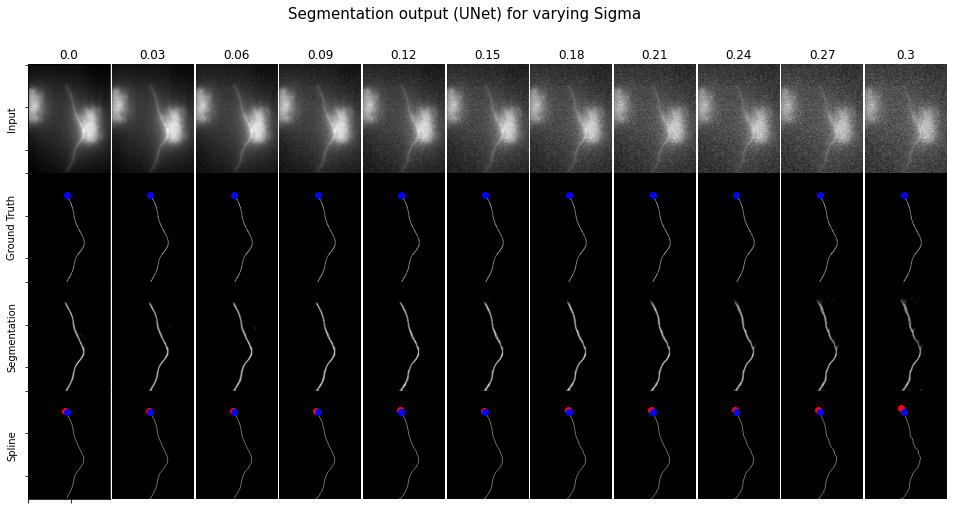

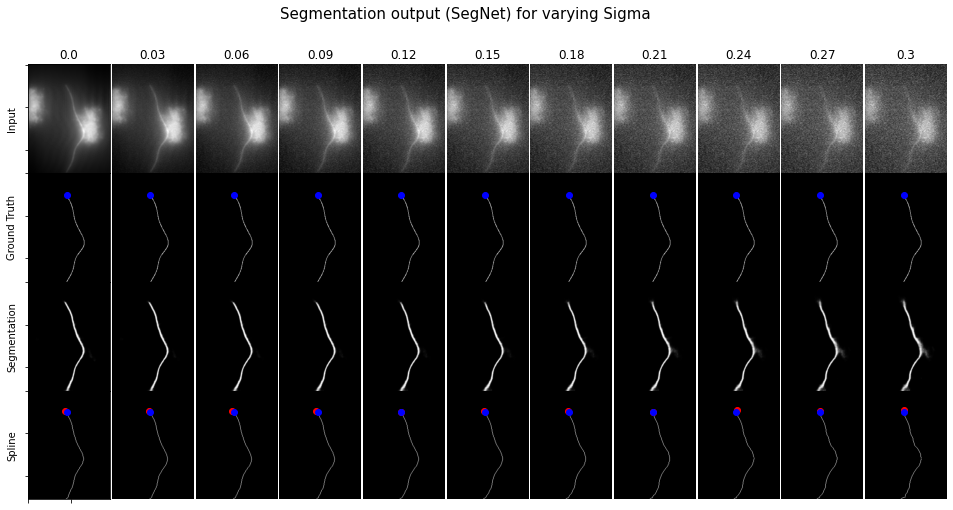

Evaluation took 27.50608777999878 seconds


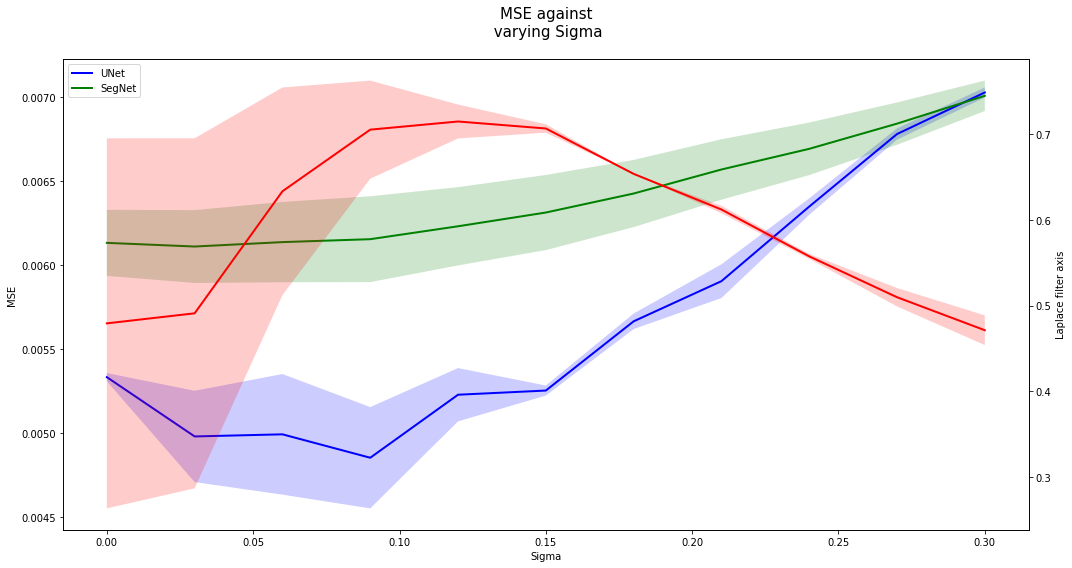

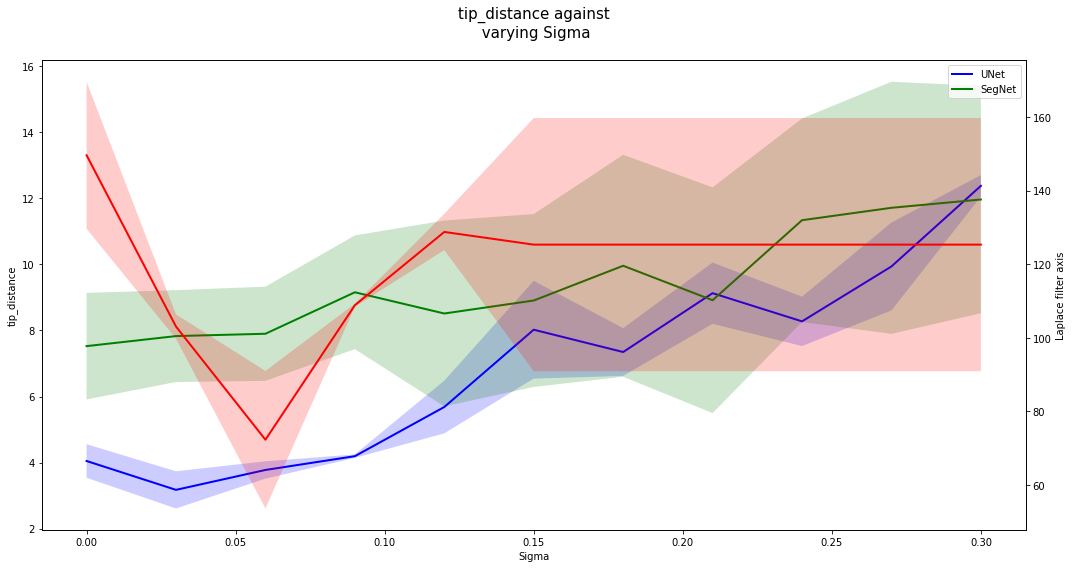

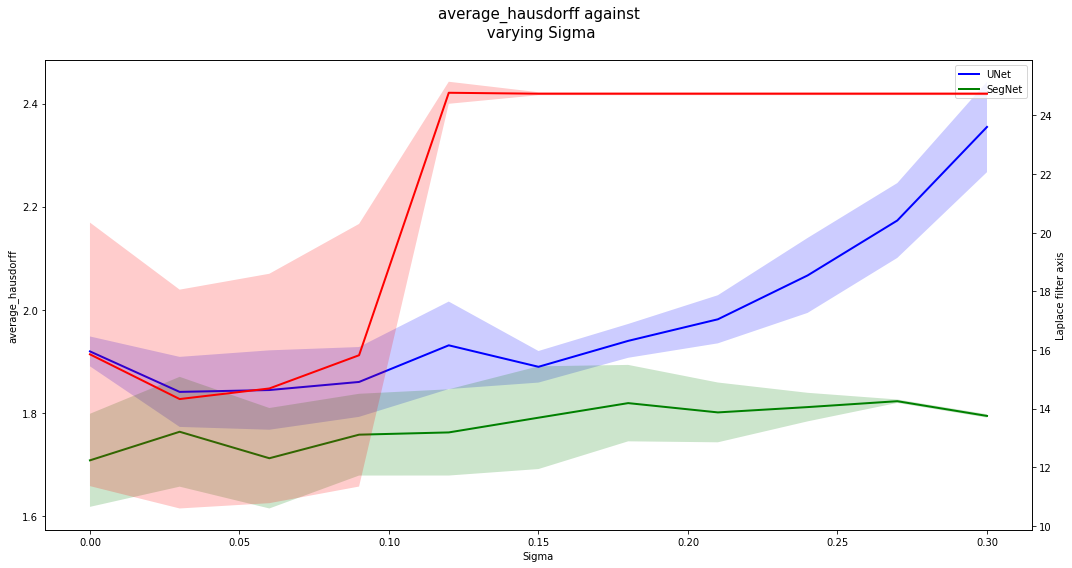

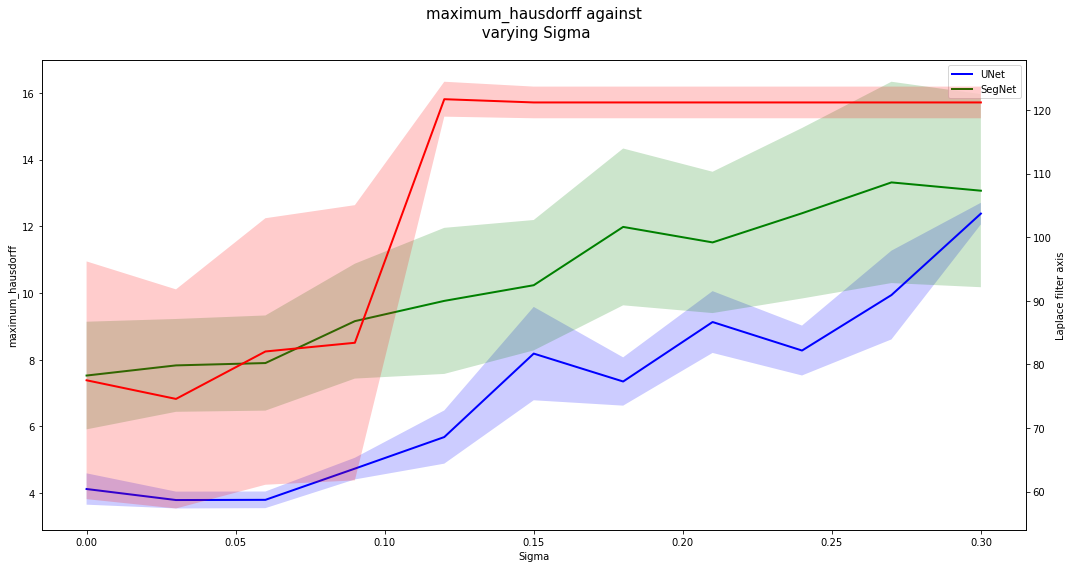

In [75]:
%cd ../segmentation
original_dir= os.getcwd()
print(original_dir)

n_values = 11
def_parameters = {}

# Change parameter to vary
def_parameters['Sigma'] = [0.1] * n_values
def_parameters['Undersampling factor'] = [1.375] * n_values
def_parameters['Undersampling spread'] = [13.0] * n_values
def_parameters['Tip current'] = [1.0] * n_values
def_parameters['Size anatomy'] = [0.5] * n_values
def_parameters['Ratio anatomy'] = [0.8] * n_values

# Example for 2 splines
parameters = def_parameters.copy()
parameters['Sigma'] = np.linspace(0, 0.3, num=n_values).tolist()
[metrics, variant, variant_pars] = evaluate_ablation(methods,[MSE],[TIP_D,HAUS_D], parameters, verbose=0, n_samples=2, experiment='results_Monte_Carlo_all_1')
plot_metric(metrics, variant, variant_pars, verbose =1, directory = 'results/results_Monte_Carlo_all_1/')


In [ ]:
# Change sigma
parameters = def_parameters.copy()
parameters['Sigma'] = np.linspace(0, 0.3, num=n_values).tolist()
[metrics, variant, variant_pars] = evaluate_ablation(methods,[MSE],[TIP_D,HAUS_D], parameters, verbose=1, n_samples=100, experiment='results_Monte_Carlo_all_1')
plot_metric(metrics, variant, variant_pars, verbose =1, directory = 'results/results_Monte_Carlo_all_1/')

# Change undersampling factor
parameters = def_parameters.copy()
parameters['Undersampling factor'] = np.linspace(0.5,1.5, num=n_values).tolist()
[metrics, variant, variant_pars] = evaluate_ablation(methods,[MSE],[TIP_D,HAUS_D], parameters, verbose=1, n_samples=100, experiment='results_Monte_Carlo_all_1')
plot_metric(metrics, variant, variant_pars, verbose =1, directory = 'results/results_Monte_Carlo_all_1/')

# Change undersampling spread
parameters = def_parameters.copy()
parameters['Undersampling spread'] = np.linspace(6.0,20.0, num=n_values).tolist()
[metrics, variant, variant_pars] = evaluate_ablation(methods,[MSE],[TIP_D,HAUS_D], parameters, verbose=1, n_samples=100, experiment='results_Monte_Carlo_all_1')
plot_metric(metrics, variant, variant_pars, verbose =1, directory = 'results/results_Monte_Carlo_all_1/')

# Change tip current
parameters = def_parameters.copy()
parameters['Tip current'] = np.linspace(0.0,1.0, num=n_values).tolist()
[metrics, variant, variant_pars] = evaluate_ablation(methods,[MSE],[TIP_D,HAUS_D], parameters, verbose=1, n_samples=100, experiment='results_Monte_Carlo_all_1')
plot_metric(metrics, variant, variant_pars, verbose =1, directory = 'results/results_Monte_Carlo_all_1/')

# Change size anatomy
parameters = def_parameters.copy()
parameters['Size anatomy'] = np.linspace(0.0,1.0, num=n_values).tolist()
[metrics, variant, variant_pars] = evaluate_ablation(methods,[MSE],[TIP_D,HAUS_D], parameters, verbose=1, n_samples=100, experiment='results_Monte_Carlo_all_1')
plot_metric(metrics, variant, variant_pars, verbose =1, directory = 'results/results_Monte_Carlo_all_1/')

# Change ratio anatomy
parameters = def_parameters.copy()
parameters['Ratio anatomy'] = np.linspace(0.6,1.0, num=n_values).tolist()
[metrics, variant, variant_pars] = evaluate_ablation(methods,[MSE],[TIP_D,HAUS_D], parameters, verbose=1, n_samples=100, experiment='results_Monte_Carlo_all_1')
plot_metric(metrics, variant, variant_pars, verbose =1, directory = 'results/results_Monte_Carlo_all_1/')
